In [16]:
from PIL import Image, ImageFilter, ImageOps
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib inline

In [3]:
def F_BringNpImg(img):
    return np.array(img.getdata()).reshape(img.size[1], img.size[0])/255

In [84]:
def F_Rotacao(img):
    img_sup = img.crop((50,0,img.size[0]-50, 30))
    np_img = F_BringNpImg(img_sup)

    dif = np_img[:,-1].sum() - np_img[:,0].sum()
    sinal = -1 if dif > 0 else 1
    
    return np.arcsin(sinal*(dif/img_sup.size[1]))

In [5]:
def F_ReduzirAltura(img, criterio = 0.9):
    
    np_img = F_BringNpImg(img)
    
    sinal = 1
    for ii in range(0,100*sinal, sinal):
        if np_img[ii, 0:img.size[0]].mean() > criterio:
            break
    
    sinal = -1
    for jj in range(0,100*sinal, sinal):
        if np_img[jj, 0:img.size[0]].mean() > criterio:
            break
    
    return ii,jj

In [6]:
def F_ReduzirLargura(img, criterio = 0.9):
    
    np_img = F_BringNpImg(img)
    
    sinal = 1
    for ii in range(0,100*sinal, sinal):
        if np_img[0:img.size[1],ii].mean() > criterio:
            break
    
    sinal = -1
    for jj in range(0,100*sinal, sinal):
        if np_img[0:img.size[1],jj].mean() > criterio:
            break
    
    return ii,jj

In [7]:
def F_CortarImagem(img):

    Top, Bottom = F_ReduzirAltura(img, criterio=0.9)
    Left, Right = F_ReduzirLargura(img, criterio=0.9)

    return img.crop((Left, Top, img.size[0] + Right, img.size[1] + Bottom))

In [8]:
def F_AumentarDensidade(img_crop, step_vert = 50, step_hor = 5):
    
    for jj in range(0, img_crop.size[1]):
        for ii in range(0, img_crop.size[0]):

            if img_crop.getpixel((ii,jj)) == 0:

                end = 0
                for kk in range(ii + 1, ii + 1 + step_hor):

                    if img_crop.getpixel((kk,jj)) == 0:
                        end = kk
                    elif kk + 1 == img_crop.size[0]:
                        break

                for ii in range(ii, end):
                    img_crop.putpixel((ii,jj),0)
    if step_vert != 0:
        for ii in range(0, img_crop.size[0]):
            for jj in range(0, img_crop.size[1]):

                if img_crop.getpixel((ii,jj)) == 0:

                    end = 0
                    for kk in range(jj + 1, jj + 1 + step_vert):

                        try:
                        #Uma exceção deve ocorrer quando chegar ao limite da imagem
                            if img_crop.getpixel((ii, kk)) == 0:
                                end = kk
                            elif kk + 1 == img_crop.size[1]:
                                break
                        except:
                            pass

                    for jj in range(jj, end):
                        img_crop.putpixel((ii,jj), 0)

    return img_crop

In [153]:
def F_VisualizarResultado(img, posicoes):
    
    img_aux = img.convert('RGB')

    #Criar visualização
    for count, posicao in enumerate(posicoes):
        try:
            for ii in range(0, 70):
                img_aux.putpixel((int(posicao[0]), ii),(255,0,0))
                img_aux.putpixel((int(posicao[1]), ii),(255,0,0))
        except:
            pass

    return img_aux

In [185]:
def F_DisplayContour(img, contours):
    # Display the image and plot all contours found
    plt.figure(figsize=(50,100))
    plt.imshow(img, interpolation='nearest')

    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=5)

    plt.axis('image')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Step 0
Carregar a imagem, rotacionar e reduzir a área de interesse

In [170]:
generator_imgs = ('{}/{}'.format('Original', ii) for ii in os.listdir('Original') if ii.endswith('F.tif'))

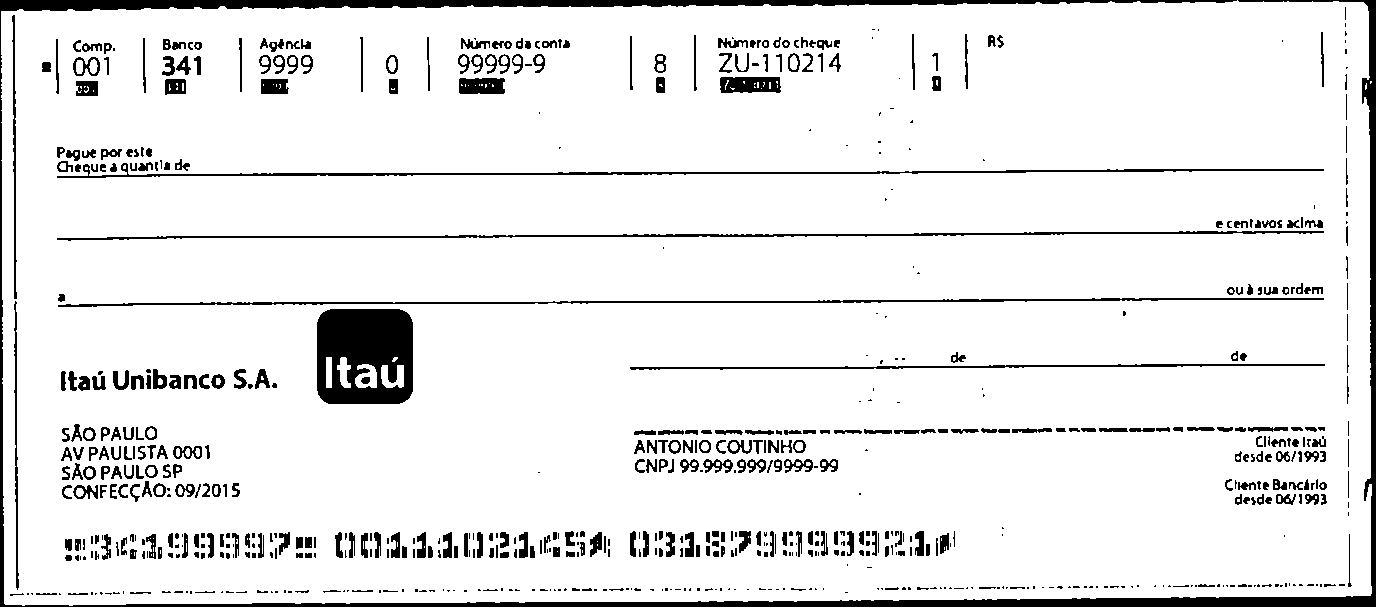

In [171]:
img = Image.open(next(generator_imgs))
img

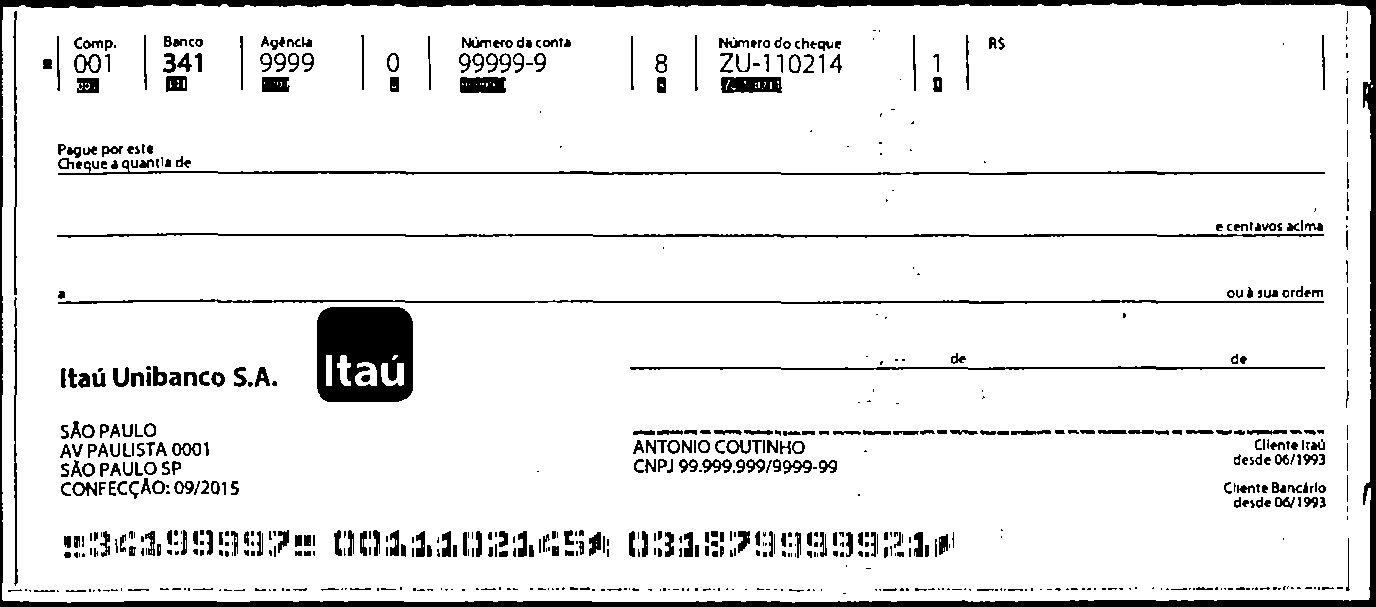

In [172]:
img = img.rotate(F_Rotacao(img))
img

Encontrei as rotações agora preciso cortar a imagem para ficar somente com a área do cheque

In [173]:
img = F_CortarImagem(img)

### Observação
Aqui é necessário definir a área de corte para imagem dos dígitos

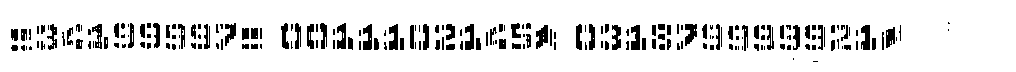

In [174]:
img_crop = img.crop((50, 500, img.size[0] - 300, img.size[1]-20))
img_crop

# Step 1
Aumentar a densidade de pontos pretos na imagem

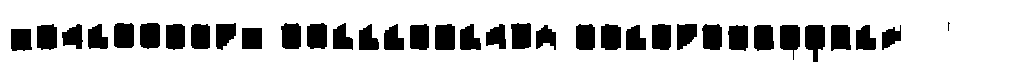

In [175]:
img_crop = F_AumentarDensidade(img_crop)
img_crop

# Step 2 
Tirar o contorno das imagens

In [176]:
#Encontrar contornos
contours = measure.find_contours(img_crop, level= .99)

# Step 3
Definir pontos de corte da imagem

In [182]:
#Encontrar contornos
contours = measure.find_contours(img_crop, level= .99)

#Guardar as posições
posicoes = [(min(contour, key=lambda x:x[1])[1], max(contour, key=lambda x:x[1])[1]) for contour in contours]

#Ordenar começando pela esquerda
posicoes = sorted(posicoes, key= lambda x:x[1])[0:33]

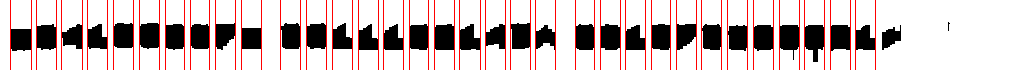

In [183]:
F_VisualizarResultado(img_crop, posicoes)

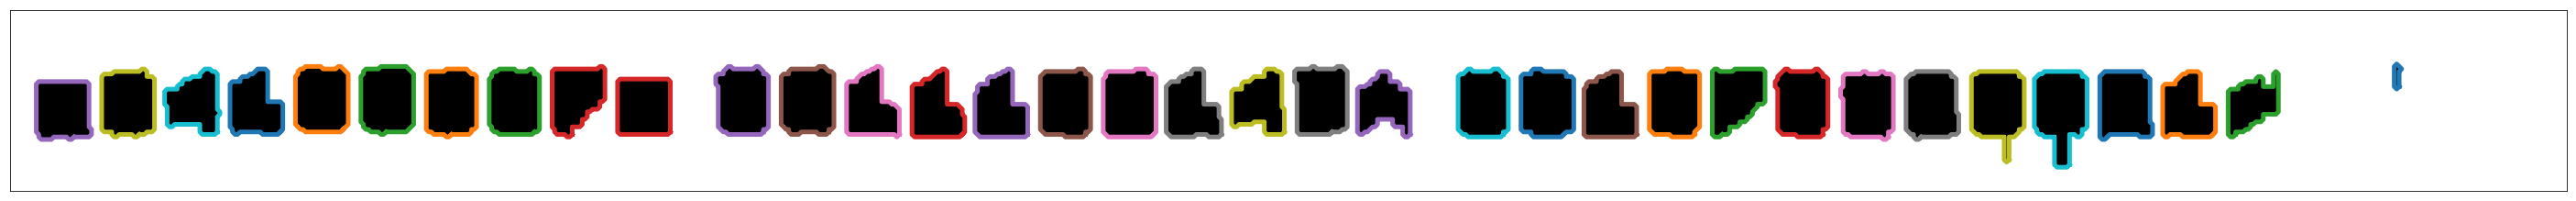

In [186]:
F_DisplayContour(img_crop, contours)

# Resultado Final

# Step 4
Agora buscar os dígitos superiores

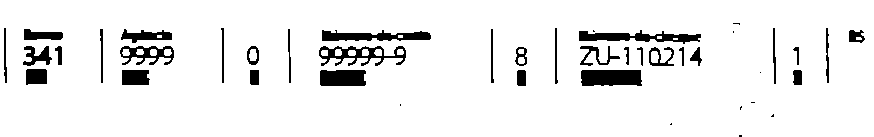

In [129]:
img_crop = img.crop((img.size[0]*0.1,0,img.size[0]*0.74, img.size[0]*0.1))

#Não utilizar análise por profundidade
img_crop = F_AumentarDensidade(img_crop, step_hor=5, step_vert=2)
img_crop

In [130]:
#Encontrar contornos
contours = measure.find_contours(img_crop, level= .99)

In [133]:
dif_abs = [(max(contour, key = lambda x:x[0])[0]-min(contour, key = lambda x:x[0])[0],n) 
                for n, contour in enumerate(contours)]

dif_ord = [ii[1] for ii in sorted(dif_abs, reverse=True)[0:8]]

posicoes = []
for jj in dif_ord:
    posicoes_aux = [ii[1] for ii in contours[jj]]
    posicoes.append((min(posicoes_aux), max(posicoes_aux)))

%reset_selective -f posicoes_aux